# TP 3  : Graph Neural Networks Architecture

**Théo Rudkiewicz, Cyriaque Rousselot**

Names:
- Carlos Cuevas Villarmin
- Oliver Jack
- Javier Alejandro Lopetegui Gonzalez

*MVA, ENS Paris-Saclay*

# TUTORIAL

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric


Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 37.0 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.0 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 53.8 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.7 MB/s eta 0:00:00


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it :

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [2]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node has:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct nodes' labels**.

**It is a node (multi-label) classification task** (trained using supervised learning, with labels to be predicted for each node).

For your curiosity, more detailed information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [ ]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Extracting ./ppi.zip
Processing...
/usr/local/lib/python3.11/dist-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


Done!


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-label) classification task, computing 121 features (for each node).

In [ ]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [ ]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Next we construct the function to train the model.

In [ ]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):
    epoch_list = []
    scores_list = []
    loss_list = []
    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))
        loss_list.append(loss_data)
        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list, loss_list

Let's train this model !

In [19]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

loss_fcn = nn.BCEWithLogitsLoss()


Device:  cuda


In [ ]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(
    device
)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores, losses = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda
Epoch 00001 | Loss: 0.6382
F1-Score: 0.4535
Epoch 00002 | Loss: 0.5810
Epoch 00003 | Loss: 0.5618
Epoch 00004 | Loss: 0.5558
Epoch 00005 | Loss: 0.5509
Epoch 00006 | Loss: 0.5464
F1-Score: 0.5057
Epoch 00007 | Loss: 0.5423
Epoch 00008 | Loss: 0.5377
Epoch 00009 | Loss: 0.5340
Epoch 00010 | Loss: 0.5314
Epoch 00011 | Loss: 0.5288
F1-Score: 0.5279
Epoch 00012 | Loss: 0.5263
Epoch 00013 | Loss: 0.5238
Epoch 00014 | Loss: 0.5215
Epoch 00015 | Loss: 0.5192
Epoch 00016 | Loss: 0.5170
F1-Score: 0.5206
Epoch 00017 | Loss: 0.5146
Epoch 00018 | Loss: 0.5123
Epoch 00019 | Loss: 0.5100
Epoch 00020 | Loss: 0.5075
Epoch 00021 | Loss: 0.5053
F1-Score: 0.5288
Epoch 00022 | Loss: 0.5033
Epoch 00023 | Loss: 0.5013
Epoch 00024 | Loss: 0.4993
Epoch 00025 | Loss: 0.4974
Epoch 00026 | Loss: 0.4955
F1-Score: 0.5406
Epoch 00027 | Loss: 0.4937
Epoch 00028 | Loss: 0.4919
Epoch 00029 | Loss: 0.4901
Epoch 00030 | Loss: 0.4883
Epoch 00031 | Loss: 0.4866
F1-Score: 0.5565
Epoch 00032 | Loss: 0.4850
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the validation set: 0.6482


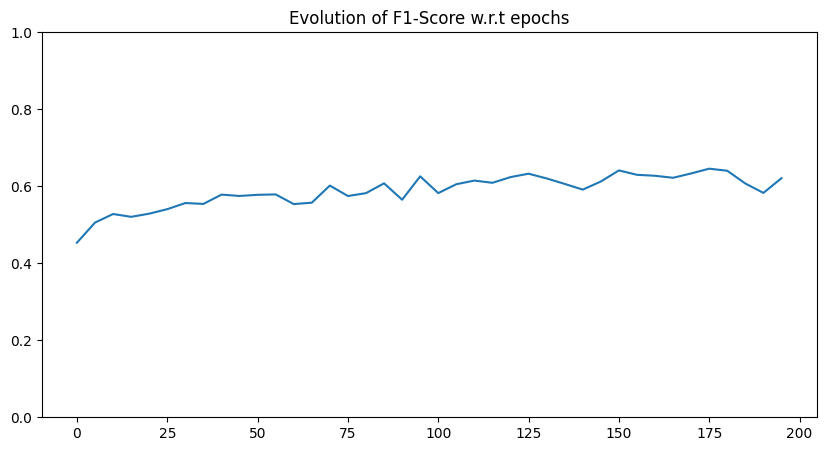

In [ ]:
### F1-SCORE ON VALID DATASET
score_valid = evaluate(basic_model, loss_fcn, device, val_dataloader)
print("Basic Model : F1-Score on the validation set: {:.4f}".format(score_valid))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide at least 4 files :
1. This Notebook
2. `class_model_gnn.py`
3. `model.pth` (the file **must be of size less than 50Mo** but 20Mo should be enough to get a very good model)
4. `conv_as_message_passing.py`

If the function you defined passes all the tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear, short and __bold font__ answers.  

> Question 1 : Design, build and train a model with a F1-score higher than 93% on validation set (**HINT :** https://arxiv.org/pdf/1710.10903.pdf).


 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `class_model_gnn.py` containing the class inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `model.pth` file : the model weights

 We will  test your model on final F1-Score on a test set. You must not use the test set for hyperparameter training.

Intermediate question :

 Provide the script for training, and a plot of the training loss.  

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import softmax

class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, att_heads, activation = nn.LeakyReLU(), dropout_prob=1, concat=True, add_skip_connection=True, device=device):
        """
        Multi-head attention mechanism for GAT.
        Args:
            input_dim: Input feature size per node
            hidden_dim: Feature size per head
            att_heads: Number of attention heads
            activation: Activation function
            dropout_prob: Dropout probability
            concat: Whether to concatenate or average attention heads
            add_skip_connection: Whether to add skip connection or not
        """
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.att_heads = att_heads
        self.activation = activation
        self.concat = concat
        self.add_skip_connection = add_skip_connection

        # Multi-head projection layer (each head gets its own transformation)
        self.projection = nn.Linear(input_dim, att_heads * hidden_dim, bias=False)

        # Attention mechanism per head (2 * hidden_dim per head)
        self.attention_e_weights = nn.Parameter(torch.Tensor(1, self.att_heads, 2 * hidden_dim))  # Attention weights: a in GAT paper

        if add_skip_connection:
            self.skip_proj = nn.Linear(input_dim, hidden_dim * att_heads, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        self.dropout = nn.Dropout(p=dropout_prob) # In the original GAT paper, for PPI it is not applied, we won't use it

        self.initialize_parameters()

        self.to(device)

    def initialize_parameters(self):
        """Apply Glorot (Xavier) initialization to weights.""" # Following the original GAT implementation
        nn.init.xavier_uniform_(self.projection.weight)
        nn.init.xavier_uniform_(self.attention_e_weights)
        if self.add_skip_connection:
            nn.init.xavier_uniform_(self.skip_proj.weight)

    def forward(self, x, edge_index):
        """
        Compute multi-head attention.
        Args:
            x: Node feature matrix of shape (batch_size, num_nodes, input_dim).
            edge_index: Edge indices (batch_size, 2, num_edges).
        Returns:
            h_prime: Updated node features (batch_size, num_nodes, att_heads * hidden_dim).
        """
        num_nodes, _ = x.shape

        # Apply linear projection to obtain multi-head representations
        h = self.projection(x)  # (batch_size, num_nodes, att_heads * hidden_dim)
        h = h.view(num_nodes, self.att_heads, self.hidden_dim)  # (batch_size, num_nodes, att_heads, hidden_dim)

        # Extract source & destination node indices
        src, dst = edge_index  # (2, num_edges)

        # Gather features for source and destination nodes
        h_src = h[src]  # (batch_size, num_edges, att_heads, hidden_dim)
        h_dst = h[dst]  # (batch_size, num_edges, att_heads, hidden_dim)

        # Concatenate source and destination embeddings along the feature dimension
        concat_h = torch.cat([h_src, h_dst], dim=-1)  # (batch_size, num_edges, att_heads, 2 * hidden_dim)

        # Compute raw attention scores
        e = torch.einsum("nah,nah -> na", concat_h, self.attention_e_weights)  # (batch_size, num_edges, att_heads)

        # Apply LeakyReLU activation to attention scores
        e = self.activation(e)

        # Compute softmax per destination node
        alpha = softmax(e, dst, num_nodes=num_nodes)  # (batch_size, num_edges, att_heads)

        # Compute weighted sum of source node features (using attention scores)
        h_prime = torch.zeros((num_nodes, self.att_heads, self.hidden_dim), device=x.device)
        h_prime.index_add_(0, dst, alpha.unsqueeze(-1) * h_src)

        # Apply skip connection (if enabled)
        if self.add_skip_connection:
            skip_output = self.skip_proj(x).view(num_nodes, self.att_heads, self.hidden_dim)
            h_prime += skip_output

        # Concatenate or average attention heads
        if self.concat:
            h_prime = h_prime.view(num_nodes, self.att_heads * self.hidden_dim)  # (batch_size, num_nodes, att_heads * hidden_dim)
        else:
            h_prime = h_prime.mean(dim=1)  # Average over heads: (num_nodes, hidden_dim)

        return h_prime  # Updated node features



# Define model ( in your class_model_gnn.py)
class StudentModel(nn.Module):
    def __init__(self, input_dim=n_features, hidden_dim = [256, 256, 121], att_heads = [4, 4, 6], device=device):
        super(StudentModel, self).__init__()
        self.att1 = MultiHeadAttention(input_dim, hidden_dim[0], att_heads[0], concat=True, add_skip_connection=True, device=device)
        self.att2 = MultiHeadAttention(hidden_dim[0] * att_heads[0], hidden_dim[1], att_heads[1], concat=True, add_skip_connection=True, device=device)
        self.att3 = MultiHeadAttention(hidden_dim[1] * att_heads[1], hidden_dim[2], att_heads[2], concat=False, add_skip_connection=True, device=device)

    def forward(self, x, edge_index):
        x = nn.ELU()(self.att1(x, edge_index))
        x = nn.ELU()(self.att2(x, edge_index))
        x = self.att3(x, edge_index)#.mean(dim=-1) # Paper indicates to do sigmoid, it is done in the loss function
                                                   # Also, mean(dim=-1) removed due to incompatible shape with target in BCE
        return x


# Initialize model
model = StudentModel()

## Save the model
# torch.save(model.state_dict(), "model.pth")


### This is the part we will run in the inference to grade your model
## Load the model
from class_model_gnn import StudentModel
model = StudentModel()  # !  Important : No argument
model.load_state_dict(torch.load("model.pth", weights_only=True))
model.eval()
print("Model loaded successfully")


Model loaded successfully
Model loaded successfully


**Same function for training is used. Losses list has been added as output to provide a plot of the training loss.**

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
epoch_list, student_model_scores, losses = train(model, loss_fcn, device, optimizer, 100, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.6927
F1-Score: 0.4747
Epoch 00002 | Loss: 0.5301
Epoch 00003 | Loss: 0.4972
Epoch 00004 | Loss: 0.4775
Epoch 00005 | Loss: 0.4578
Epoch 00006 | Loss: 0.4425
F1-Score: 0.6171
Epoch 00007 | Loss: 0.4133
Epoch 00008 | Loss: 0.3853
Epoch 00009 | Loss: 0.3548
Epoch 00010 | Loss: 0.3371
Epoch 00011 | Loss: 0.2996
F1-Score: 0.7656
Epoch 00012 | Loss: 0.2652
Epoch 00013 | Loss: 0.2333
Epoch 00014 | Loss: 0.2082
Epoch 00015 | Loss: 0.1772
Epoch 00016 | Loss: 0.1535
F1-Score: 0.8875
Epoch 00017 | Loss: 0.1327
Epoch 00018 | Loss: 0.1174
Epoch 00019 | Loss: 0.1088
Epoch 00020 | Loss: 0.1049
Epoch 00021 | Loss: 0.1066
F1-Score: 0.9220
Epoch 00022 | Loss: 0.0910
Epoch 00023 | Loss: 0.0786
Epoch 00024 | Loss: 0.0692
Epoch 00025 | Loss: 0.0628
Epoch 00026 | Loss: 0.0605
F1-Score: 0.9467
Epoch 00027 | Loss: 0.0547
Epoch 00028 | Loss: 0.0513
Epoch 00029 | Loss: 0.0475
Epoch 00030 | Loss: 0.0431
Epoch 00031 | Loss: 0.0395
F1-Score: 0.9635
Epoch 00032 | Loss: 0.0360
Epoch 00033 | Los

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "model.pth")

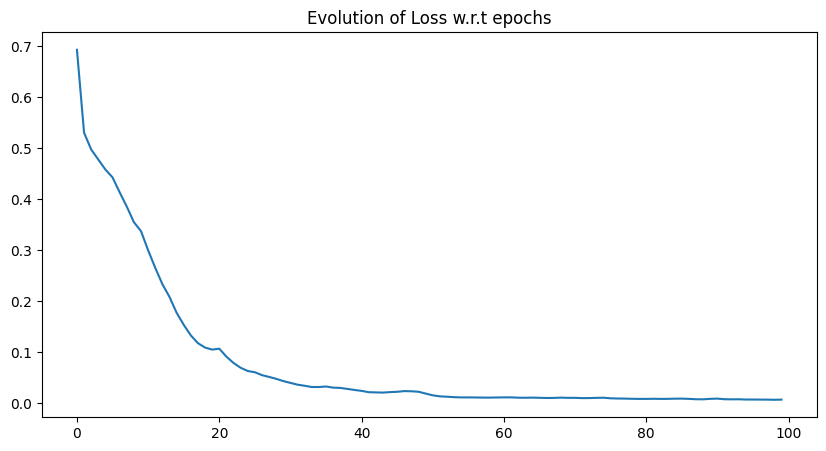

Basic Model : F1-Score on the validation set: 0.9813


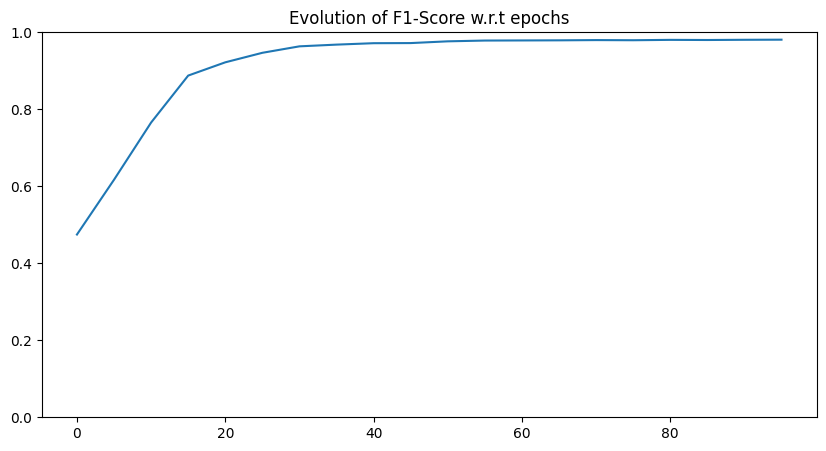

In [ ]:
### LOSS EVOLUTION
def plot_loss(losses):
    plt.figure(figsize=[10, 5])
    plt.plot(losses)
    plt.title("Evolution of Loss w.r.t epochs")
    plt.show()

plot_loss(losses)

### F1-SCORE ON VALID DATASET
score_valid = evaluate(model, loss_fcn, device, val_dataloader)
print("Basic Model : F1-Score on the validation set: {:.4f}".format(score_valid))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()

plot_f1_score(epoch_list, student_model_scores)

## Conv 2D as Message Passing Neural Network


## Introduction

The use of graph is a way to structure data by adding neighborhood information between features. This then allows to do operations on the data that are local to each node and its neighbors. This is the main idea behind Graph Neural Networks (GNNs). [`pytorch-geometric`](https://pytorch-geometric.readthedocs.io/en/latest/) is a library compatible with PyTorch that allows to easily implement GNNs. The most general structure is the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) class that is then used as a base for more specific GNNs as seen in the course ([Graph Convolutional Networks](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv) or [Graph AttenTion Convolution](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv)).

On the other hand, you already know an operation that uses the structure of the data to do local operations: the convolution (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). One can see the convolution as a specific case of the message passing neural network. The goal of this notebook is to show how to use the `MessagePassing` class to implement a convolutional neural network.
You will be asked to implement 3 functions. You should give back those three functions in a file named `conv_as_message_passing.py`. These functions will then be automatically tested. So be sure to respect the function signature and the function name.


## Assumptions

To make the implementation easier we will make some assumptions:
- the input is a single image (batch size of 1) of size 'C x H x W'
- the convolution will be a 3x3 kernel with stride 1 and padding 1.

You may also assume that the Conv2D layer has no bias but it will be slightly penalized in the grading.

Bonus points will be given if you can handle the cases that are not covered by those assumptions.


## Questions

### Question 2

> Using the formalism used in the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) documentation (and on [wikipedia](https://en.wikipedia.org/wiki/Graph_neural_network#Message_passing_layers) with sligthly different notations), explain how theorically you can simulate a 2D convolution using the `MessagePassing` formalism. This may include a pre-processing step to transform the image into a graph and then a post-processing step to transform the graph back into an image. (:warning: Those steps should be independent of the parameters of the convolution, but not necessarily from the hyper-parameters.)
$$\mathbf{x}_{i}^{\prime} = \gamma_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\bigoplus\limits_{j \in \mathcal{N}(i)}\,\phi_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{j,i} \right) \right),$$


HINT : It is possible to do it with the following $\gamma$ :

$$ \gamma_\Theta : x,y \mapsto y $$


**ANSWER:** For our reasoning, let us stick to the assumptions made previously, namely that the image is of size $C \times H \times W$ and that the convolution will be a kernel of size $3 \times 3$ with stride 1 and padding 1.

First, the image can be represented as a graph where each pixel corresponds to a node. For an image with dimensions $C \times H \times W$, we create a graph with $H \times W$ nodes, where each node has a feature vector of dimension $C$ corresponding to the channel values of the respective pixel.

As far as the potential edges are concerned, for each node representing a pixel at position $(i,j)$, we can create incoming edges from all pixels in its $3 \times 3$ neighborhood (including itself). This means each node receives messages from at most 9 neighbors (or exactly 9 if we consider padding), corresponding to the 9 positions in a $3 \times 3$ convolution kernel. We also associate each edge with an attribute $\mathbf{e}_{j,i}$ that encodes the relative position of the source pixel in the kernel with respect to the target pixel, e.g. in the case of a $3 \times 3$ kernel:

\begin{array}{ccc}
(-1,-1) & (0,-1) & (1,-1) \\
(-1,0) & (0,0) & (1,0) \\
(-1,1) & (0,1) & (1,1)
\end{array}


The message function $\phi_{{\Theta}}$ is defined to multiply the source node's features by the corresponding kernel weight based on the relative position:

$$\phi_{{\Theta}}(\mathbf{x}_i, \mathbf{x}_j, \mathbf{e}_{j,i}) = W_{\text{pos}(\mathbf{e}_{j,i})} \cdot \mathbf{x}_j$$

where $W_{\text{pos}(\mathbf{e}_{j,i})}$ is the weight matrix corresponding to the position encoded in $\mathbf{e}_{j,i}$. For a $3 \times 3$ kernel, we have 9 different weight matrices, one for each position in the kernel.

Next, the aggregation function is simply a sum, coinciding with the summation in the convolution operation:

$$\bigoplus\limits_{j \in \mathcal{N}(i)}\,\phi_{{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{j,i} \right) = \sum_{j \in \mathcal{N}(i)} W_{\text{pos}(\mathbf{e}_{j,i})} \cdot \mathbf{x}_j$$

Finally, as suggested in the hint, the update function $\gamma_{{\Theta}}$ can be defined as $\gamma_{\Theta}(x, y) = y$, meaning we simply use the result of the aggregation as the new node feature without transforming it any further:

$$\mathbf{x}_{i}^{\prime} = \sum_{j \in \mathcal{N}(i)} W_{\text{pos}(\mathbf{e}_{j,i})} \cdot \mathbf{x}_j$$

From this last equation we can conclude that the formalism exactly corresponds to the 2D convolution operation, since for each output pixel, we compute a weighted sum of its neighborhood, where the weights are given by the convolution kernel.

(Note: This reasoning can easily be extended to a kernel of any size, as well as any other padding or stride value. Moreover, to extend it to the case where we have a batch containing multiple images, the process stays almost the same, as the graph structure will differ just in the number of nodes considered (it will be B times bigger than the original one). We will have B different graphs that will not affect the values of the other ones as it just deppend on the edges.)

In [3]:
import torch
import torch_geometric
from torch_geometric.data import Batch

### Question 3

> Implement the pre-processing function, you can use the follwing code skeleton (you may change the output type, it is just a strong suggestion):

In [4]:
def image_to_graph(
    images: torch.Tensor, conv2d: nn.Conv2d | None = None
) -> Batch:
    """
    Converts a batch of images to a PyTorch Geometric Batch object.

    Arguments:
    ----------
    images : torch.Tensor
        Image tensor of shape (B, C, H, W) or (C, H, W).
    conv2d : torch.nn.Conv2d, optional
        Convolution layer that determines kernel_size, stride, and padding (if desired).
        By default, None.

    Returns:
    --------
    torch_geometric.data.Batch
        A batched graph representation of all images.
    """
    # Check image dimension
    if images.dim() == 3:
        images = images.unsqueeze(0) # Batch_size = 1

    kernel_size = conv2d.kernel_size if conv2d is not None else (3, 3)
    stride = conv2d.stride if conv2d is not None else (1, 1)
    padding = conv2d.padding if conv2d is not None else (1, 1)

    B, C, H, W = images.shape
    data_list = []

    # image size after applying convolution
    H_o = (H + 2 * padding[0] - kernel_size[0]) // stride[0] + 1
    W_o = (W + 2 * padding[1] - kernel_size[1]) // stride[1] + 1

    # padded image size
    H_padded, W_padded = H + 2 * padding[0], W + 2 * padding[1]

    # iterate over batch elements to bulid the graph representation for each image
    for i in range(B):
        image = images[i]

        padded_image = torch.nn.functional.pad(image, (padding[1], padding[1], padding[0], padding[0]))

        edge_index = []
        edge_attr = []

        for i in range(H_o):
            for j in range(W_o):
                start_i = i * stride[0]
                start_j = j * stride[1]

                # target node
                target_idx = i * W_o + j

                # iterate over all possible source nodes
                for ki in range(kernel_size[0]):
                    for kj in range(kernel_size[1]):
                        src_i = start_i + ki
                        src_j = start_j + kj

                        if 0 <= src_i < H_padded and 0 <= src_j < W_padded:
                            src_idx = src_i * W_padded + src_j

                            edge_index.append([src_idx, target_idx])

                            kernel_pos = ki * kernel_size[1] + kj
                            edge_attr.append([kernel_pos])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        x = padded_image.permute(1, 2, 0).reshape(H_padded * W_padded, C)
        data = torch_geometric.data.Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data_list.append(data)

    batch = Batch.from_data_list(data_list)

    return batch

### Question 4

> Implement the post-processing function, you can use the follwing code skeleton:

In [5]:
def graph_to_image(
    data: torch.Tensor,
    height: int,
    width: int,
    conv2d: torch.nn.Conv2d | None = None
) -> torch.Tensor:
    """
    Converts a graph representation of a batch of images to a 4D image tensor (B, C, H_out, W_out). B can be 1 for an individual image

    Arguments:
    ----------
    data : torch.Tensor
        Graph data representation of the batch of images. Shape should be (B*n_pixels, C) where n_pixels = H_o * W_o.
    height : int
        Height of the image.
    width : int
        Width of the image.
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None

    Returns:
    --------
    torch.Tensor
        (B, C, new_height, new_width),
        where B = 1 for a single graph, or batch.num_graphs for a Batch.
    """

    n_pixels, C = data.shape

    # extract kernel properties
    padding = conv2d.padding if conv2d is not None else (1, 1)
    kernel_size = conv2d.kernel_size if conv2d is not None else (3, 3)
    stride = conv2d.stride if conv2d is not None else (1, 1)

    # Padded dimensions
    H_padded = height + 2 * padding[0]
    W_padded = width + 2 * padding[1]

    # Image size after convolution
    H_o = (height + 2 * padding[0] - kernel_size[0]) // stride[0] + 1
    W_o = (width + 2 * padding[1] - kernel_size[1]) // stride[1] + 1

    # Determine the batch_size: we consider two cases, that the image size match with the one after applying the convolution or it is the
    # one from the padded image, which can be the case if you do not apply the convolution and just want to retrieve the original image.
    # If the method instead of receiving the tensor corresponding to the data could receive the torch_geometric.data.Batch instance, we
    # would directly ask for the batch size.
    padded_flag = False
    if n_pixels % (H_o * W_o) == 0:
      single_image_size = H_o * W_o
    elif n_pixels % (H_padded * W_padded) == 0:
      single_image_size = H_padded * W_padded
      padded_flag = True
    else:
      raise ValueError("n_pixels must be divisible by H_padded * W_padded or H_o * W_o")

    batch_size = n_pixels / single_image_size
    B = int(batch_size)

    images_list = []
    # iterate over the elements in the batch to retrieve the corresponding image
    for graph_idx in range(B):
        image = data[graph_idx*single_image_size:(graph_idx+1)*single_image_size]

        # Dealing with padded input features
        if padded_flag:
            padded_image = image.reshape(H_padded, W_padded, C)
            padded_image = padded_image.permute(2, 0, 1)

            image = padded_image[:, padding[0]:padding[0]+height, padding[1]:padding[1]+width]

        else: # Dealing with output features
            kernel_size = conv2d.kernel_size if conv2d is not None else (3, 3)
            stride = conv2d.stride if conv2d is not None else (1, 1)

            image = image.reshape(H_o, W_o, C)
            image = image.permute(2, 0, 1)

        images_list.append(image)

    # Stack into (B, C, new_height, new_width)
    out = torch.stack(images_list, dim=0)
    if B == 1:
        out = out.squeeze(0)

    return out

#### Recommended test cases

We **encourage** you to test that you have the property that the pre-processing function followed by the post-processing function is the identity function.

In [6]:
ref_conv = torch.nn.Conv2d(5, 7, kernel_size=3, padding=1, stride=1)
image = torch.randn(5, 10, 11)
g_image = image_to_graph(image, ref_conv)
reconstructed_image = graph_to_image(g_image.x, 10, 11, ref_conv)
assert torch.allclose(image, reconstructed_image)

In [7]:
# another test with batch_size > 1
ref_conv = torch.nn.Conv2d(5, 7, kernel_size=3, padding=1, stride=1)
image = torch.randn(2, 5, 10, 11)
g_image = image_to_graph(image, ref_conv)
reconstructed_image = graph_to_image(g_image.x, 10, 11, ref_conv)
assert torch.allclose(image, reconstructed_image)

### Question 5

> Implement the `Conv2dMessagePassing` class that will simulate a 2D convolution using the `MessagePassing` formalism.
You should inherit from the `MessagePassing` class and only change the `__init__` and `message` functions (the `forward` function has already been changed for you). You should use the following code skeleton:

In [8]:
class Conv2dMessagePassing(torch_geometric.nn.MessagePassing):
    """
    A Message Passing layer that simulates a given Conv2d layer.
    """

    def __init__(self, conv2d: torch.nn.Conv2d):
        super().__init__(aggr="add")

        # Store the Conv2d layer parameters
        self.conv2d = conv2d
        self.in_channels = conv2d.in_channels
        self.out_channels = conv2d.out_channels
        self.kernel_size = conv2d.kernel_size
        self.padding = conv2d.padding
        self.stride = conv2d.stride

        # Extract weights and bias
        self.weight = conv2d.weight
        self.bias = conv2d.bias

    def forward(self, data):
        self.edge_index = data.edge_index

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        return out

    def message(self, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        """
        Computes the message to be passed for each edge.
        For each edge e = (u, v) in the graph indexed by i,
        the message trough the edge e (ie from node u to node v)
        should be returned as the i-th line of the output tensor.
        (The message is phi(u, v, e) in the formalism.)
        To do this you can access the features of the source node
        in x_j[i] and the attributes of the edge in edge_attr[i].

        Arguments:
        ----------
        x_j : torch.Tensor
            The features of the souce node for each edge (of size E x in_channels).
        edge_attr : torch.Tensor
            The attributes of the edge (of size E x edge_attr_dim).

        Returns:
        --------
        torch.Tensor
            The message to be passed for each edge (of size COMPLETE)
        """
        # Extract kernel positions from edge attributes
        kernel_pos = edge_attr[:, 0].long()

        # Count the number of incident edges for each target node
        max_index = torch.max(self.edge_index[1]) + 1
        num_incident_edges = torch.zeros(max_index, device=x_j.device)
        num_incident_edges.scatter_add_(0, self.edge_index[1], torch.ones_like(self.edge_index[1], dtype=torch.float))


        # Reshape and permute the weight tensor for efficient computation
        weights = self.weight.view(self.out_channels, self.in_channels, -1)
        weights = weights.permute(2, 0, 1)  # [kernel_size[0] * kernel_size[1], out_channels, in_channels]

        # Gather the appropriate weight slices
        weight_slices = weights[kernel_pos]  # [num_edges, out_channels, in_channels]

        # Apply weights to source feature
        messages = torch.einsum('eoi,ei->eo', weight_slices, x_j)  # [num_edges, out_channels]

        # Add bias divided by the number of incident edges if present (later in aggregation it will be added to each feature as the original bias value)
        if self.bias is not None:
            target_indices = self.edge_index[1]
            bias_divided = self.bias / num_incident_edges[target_indices].unsqueeze(1)
            messages += bias_divided

        return messages

    # with this method we make sure that it will retrieve the representation of the image after applying the convolution, removing all
    # the rest of the pixels
    def update(self, aggr_out: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        # Get unique target nodes (output nodes)
        target_nodes = torch.unique(self.edge_index[1])

        # Extract only the aggregated output for target nodes
        output_features = aggr_out[target_nodes]

        return output_features

## Test example

In [14]:
from conv_as_message_passing import image_to_graph, graph_to_image, Conv2dMessagePassing

c = 5
h = 10
w = 11

ref_conv = torch.nn.Conv2d(c, 2, kernel_size=3, padding=1, stride=1, bias=False)
image = torch.randn(c, h, w)
g_image = image_to_graph(image, ref_conv)
ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)

conv_mp = Conv2dMessagePassing(ref_conv)
g_image = conv_mp(g_image)

y_th = ref_conv(image)

ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)
reconstructed_image = graph_to_image(g_image, h, w, ref_conv)

assert torch.allclose(y_th, reconstructed_image, atol=1e-4)


In [13]:
# another example with batch_size > 1, bigger image and another kernel
c = 5
h = 100
w = 100

ref_conv = torch.nn.Conv2d(c, 100, kernel_size=10, padding=3, stride=2, bias=True)
image = torch.randn(5, c, h, w)
g_image = image_to_graph(image, ref_conv)
ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)


conv_mp = Conv2dMessagePassing(ref_conv)
g_image = conv_mp(g_image)

y_th = ref_conv(image)
ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)
reconstructed_image = graph_to_image(g_image, h, w, ref_conv)

assert torch.allclose(y_th, reconstructed_image, atol=1e-4)